In [111]:
import yaml
import pickle
import pandas as pd
import numpy as np
import lightgbm as lgb
import math

from sklearn import metrics
import matplotlib.pyplot as plt

In [91]:
with open('..\params.yaml', 'r') as fd:
    params = yaml.safe_load(fd)

In [92]:
pickledir = params['prepare-step2']['pickle-dir']
with open('../' + pickledir, 'rb') as fd:
    each_faction_dataset = pickle.load(fd)


In [93]:
featsauren = each_faction_dataset['auren']['features']
vpauren = each_faction_dataset['auren']['vp']
print(featsauren)
print(vpauren)

                r1_SCORE1  r1_SCORE2  r1_SCORE3  r1_SCORE4  r1_SCORE5  \
game                                                                    
0000000                 0          0          0          0          0   
00001201                1          0          0          0          0   
000015                  0          0          0          0          1   
00009                   0          1          0          0          0   
0001FIREandICE          0          0          1          0          0   
...                   ...        ...        ...        ...        ...   
zzt0405                 0          0          0          1          0   
zzzeagle02              0          0          1          0          0   
zzzeagle04              0          1          0          0          0   
zzzeagle06              0          0          0          0          0   
zzzzzz                  0          0          0          0          1   

                r1_SCORE6  r1_SCORE7  r1_SCORE8  r

In [95]:
vpdfdir = params['prepare']['vp-data-dir']
print(vpdfdir)
vpdf = pd.read_csv('../' + vpdfdir)
vpdf.head()

data/faction-picker-bot/vpdata.csv


,Unnamed: 0,game,witches,auren,swarmlings,mermaids,cultists,halflings,dwarves,engineers,chaosmagicians,giants,fakirs,nomads,darklings,alchemists
0,0,0000000001,NaN,NaN,NaN,118.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,050615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0,NaN
2,2,0512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0,101.0,NaN,NaN,NaN,NaN,NaN
3,3,051501,NaN,84.0,NaN,NaN,NaN,77.0,NaN,NaN,72.0,NaN,NaN,54.0,78.0,NaN
4,4,060303,NaN,NaN,NaN,108.0,NaN,NaN,NaN,121.0,NaN,NaN,78.0,NaN,128.0,NaN


In [98]:
featdfdir = params['prepare']['feature-data-dir']
print(featdfdir)
vpdf = pd.read_csv('../' + vpdfdir)
vpdf.head()

data/faction-picker-bot/featdata.csv


,Unnamed: 0,game,witches,auren,swarmlings,mermaids,cultists,halflings,dwarves,engineers,chaosmagicians,giants,fakirs,nomads,darklings,alchemists
0,0,0000000001,NaN,NaN,NaN,118.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,050615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0,NaN
2,2,0512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0,101.0,NaN,NaN,NaN,NaN,NaN
3,3,051501,NaN,84.0,NaN,NaN,NaN,77.0,NaN,NaN,72.0,NaN,NaN,54.0,78.0,NaN
4,4,060303,NaN,NaN,NaN,108.0,NaN,NaN,NaN,121.0,NaN,NaN,78.0,NaN,128.0,NaN


In [99]:
print(featsauren.shape)
print(vpauren.shape)

(11610, 71)
(11610,)


In [100]:
len(set(featsauren.index) ^ set(vpauren.index))

0

## Do the model training with Swarmings

In [101]:
faction = 'swarmlings'

In [102]:
Xdata = each_faction_dataset[faction]['features']
traindata = lgb.Dataset(Xdata, label=np.array(each_faction_dataset[faction]['vp']))

In [103]:
Xdata.columns

Index(['r1_SCORE1', 'r1_SCORE2', 'r1_SCORE3', 'r1_SCORE4', 'r1_SCORE5',
       'r1_SCORE6', 'r1_SCORE7', 'r1_SCORE8', 'r1_SCORE9', 'r2_SCORE1',
       'r2_SCORE2', 'r2_SCORE3', 'r2_SCORE4', 'r2_SCORE5', 'r2_SCORE6',
       'r2_SCORE7', 'r2_SCORE8', 'r2_SCORE9', 'r3_SCORE1', 'r3_SCORE2',
       'r3_SCORE3', 'r3_SCORE4', 'r3_SCORE5', 'r3_SCORE6', 'r3_SCORE7',
       'r3_SCORE8', 'r3_SCORE9', 'r4_SCORE1', 'r4_SCORE2', 'r4_SCORE3',
       'r4_SCORE4', 'r4_SCORE5', 'r4_SCORE6', 'r4_SCORE7', 'r4_SCORE8',
       'r4_SCORE9', 'r5_SCORE1', 'r5_SCORE2', 'r5_SCORE3', 'r5_SCORE4',
       'r5_SCORE5', 'r5_SCORE6', 'r5_SCORE7', 'r5_SCORE8', 'r5_SCORE9',
       'r6_SCORE1', 'r6_SCORE2', 'r6_SCORE3', 'r6_SCORE4', 'r6_SCORE5',
       'r6_SCORE6', 'r6_SCORE7', 'r6_SCORE8', 'r6_SCORE9', 'BON1', 'BON2',
       'BON3', 'BON4', 'BON5', 'BON6', 'BON7', 'BON8', 'BON9', 'BON10',
       '2players', '3players', '4players', '5players', 'map1', 'map2', 'map3'],
      dtype='object')

In [105]:
trainlen = math.ceil(Xdata.shape[0] * 0.8)
vallen = math.ceil(Xdata.shape[0] * 0.9)
traindata = Xdata.iloc[:trainlen, :]
trainy = np.array(each_faction_dataset[faction]['vp'].iloc[:trainlen])
valdata = Xdata.iloc[trainlen:vallen, :]
valy = np.array(each_faction_dataset[faction]['vp'].iloc[trainlen:vallen])
testdata = Xdata.iloc[vallen:, :]
testy = np.array(each_faction_dataset[faction]['vp'].iloc[vallen:])
print(traindata.shape)
print(valdata.shape)
print(testdata.shape)
print(type(traindata))

(22374, 71)
(2797, 71)
(2796, 71)
<class 'pandas.core.frame.DataFrame'>


In [106]:
traindataset = lgb.Dataset(traindata, label=trainy)
valdataset = traindataset.create_valid(valdata, label=valy)

In [107]:
len(np.array(each_faction_dataset[faction]['vp']))

27967

In [211]:
num_round=300
num_leaves=7
scikitAPI = True
max_depth = 4

if scikitAPI:
    bst = lgb.LGBMRegressor(num_leaves=num_leaves, n_estimators=num_round, max_depth=max_depth)
    bst.fit(traindata, trainy, eval_set=[(valdata, valy)] , eval_metric='l2', early_stopping_rounds=200)
else:
    param = {'num_leaves': num_leaves, 'objective': 'regression'}
    bst = lgb.train(param, traindataset, num_round)

[1]	valid_0's l2: 738.705
Training until validation scores don't improve for 200 rounds
[2]	valid_0's l2: 726.808
[3]	valid_0's l2: 716.574
[4]	valid_0's l2: 708.383
[5]	valid_0's l2: 700.558
[6]	valid_0's l2: 693.694
[7]	valid_0's l2: 689.144
[8]	valid_0's l2: 683.697
[9]	valid_0's l2: 679.3
[10]	valid_0's l2: 676.374
[11]	valid_0's l2: 673.674
[12]	valid_0's l2: 670.291
[13]	valid_0's l2: 667.302
[14]	valid_0's l2: 666.119
[15]	valid_0's l2: 663.295
[16]	valid_0's l2: 661.886
[17]	valid_0's l2: 659.827
[18]	valid_0's l2: 658.732
[19]	valid_0's l2: 656.445
[20]	valid_0's l2: 654.29
[21]	valid_0's l2: 652.158
[22]	valid_0's l2: 651.205
[23]	valid_0's l2: 650.166
[24]	valid_0's l2: 648.721
[25]	valid_0's l2: 647.381
[26]	valid_0's l2: 646.135
[27]	valid_0's l2: 645.624
[28]	valid_0's l2: 644.323
[29]	valid_0's l2: 643.385
[30]	valid_0's l2: 642.375
[31]	valid_0's l2: 641.618
[32]	valid_0's l2: 640.418
[33]	valid_0's l2: 639.126
[34]	valid_0's l2: 637.837
[35]	valid_0's l2: 637.203
[36]	

In [212]:
ytrainpred = bst.predict(traindata)
MAE = metrics.mean_absolute_error(ytrainpred, trainy)
MAE

17.317296619322786

In [213]:
ypred = bst.predict(testdata)

In [214]:
MAE = metrics.mean_absolute_error(ypred, testy)
MAE

19.040466408418137

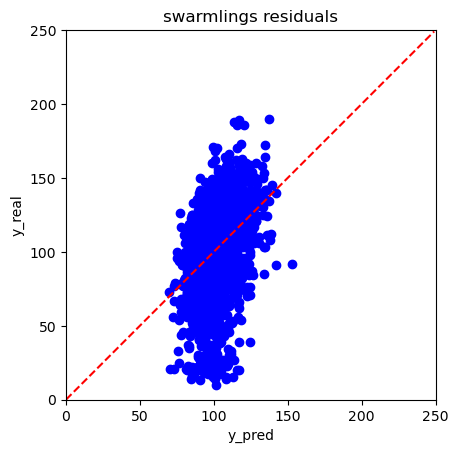

In [208]:
line = list(range(250))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'{faction} residuals')
plt.plot(ypred, testy, 'bo', line, line, 'r--')
plt.xlabel('y_pred')
plt.ylabel('y_real')
plt.xlim([0, 250])
plt.ylim([0, 250])
plt.show()

In [209]:
residuals = np.array(ypred) - np.array(testy)
avgres = np.mean(residuals)
original = np.array(testy) - np.mean(testy)
maxorig = math.ceil(np.max(original))
minorig = math.floor(np.min(original))
bins_list = list(range(minorig, maxorig))

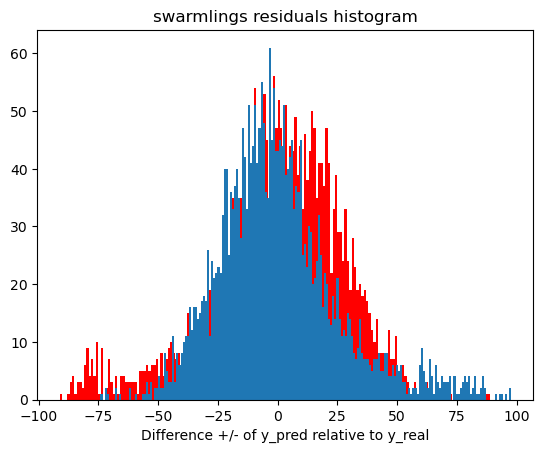

In [210]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f'{faction} residuals histogram')
plt.hist(original, bins=bins_list, color='r')
plt.hist(residuals, bins=200)
plt.xlabel('Difference +/- of y_pred relative to y_real')
#h = ax.plot([avgres, avgres], [0, 600], 'r--')
plt.show()

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title(f'{faction} residuals')
ax1.plot(ypred, np.array(testy, 'bo', line, line, 'r--')
ax1.set(xlabel='y_pred', ylabel='y_real')
ax1.set(xlim=[0, 250], ylim=[0, 250])

ax2.set_title(f'{faction} residuals histogram')
ax2.hist(residuals, bins=100)
ax2.set(xlabel='Difference +/- of y_pred relative to y_real')
h = ax2.plot([avgres, avgres], [0, 600], 'r--')
plt.show()

SyntaxError: invalid syntax (<ipython-input-58-3d01449f4790>, line 5)

In [ ]:
# metricsdir = 'data/faction-picker-bot/metrics/'
# plt.savefig(metricsdir + f'{faction} charts.png')